In [1]:
from tqdm import tqdm 
import copy
import numpy as np
from scipy.special import digamma, loggamma
import time
import matplotlib.pyplot as plt

In [153]:
K = 20 # Number of topics
V = 50 # Number of terms in the vocabulary
N = 10 # Number of documents
M = 20 # Number of words per document
ETA = 0.5 # Hyperparameter for V-Dirichlet topics prior
ALPHA = 0.5 # Hyperparameter for K-Dirichlet topics proportion prior

def sim_LDA(K, V, N, M):
    # For each topic in k = 1,...,K, draw topic distributions
    BETA = np.random.dirichlet(ETA * np.ones(V), K)

    X = [] # Initialize empty list for complete collection of documents
    for i in range(N): # Iterate over number of documents i = 1,...,N
        THETA = np.random.dirichlet(ALPHA * np.ones(K), N) # Draw topic proportions
        x = []
        for _ in range(M): # Iterate over each word
            z_ij = np.random.choice(K, p=THETA[i]) # Draw topic assignment
            x_ij = np.random.choice(V, p=BETA[z_ij]) # Draw observed word
            x.append(x_ij)
        X.append(x)

    X = np.asarray(X) # Convert collection of documents to numpy array
    return X
X = sim_LDA(K, V, N, M)

In [154]:
def init_variation_params(X):
    N, M = X.shape
    LAMBDA = np.random.uniform(low=0.01, high=3.00, size=(K, V))
    GAMMA = np.ones(shape=(N, K))
    PHI = np.ones(shape=(N, M, K)) * (1 / K)

    return LAMBDA, GAMMA, PHI

In [155]:
def compute_ELBO(LAMBDA, GAMMA, PHI, X):
    N, M = X.shape
    ELBO = 0

    E_log_p_BETA = 0
    for k in range(K):
        E_log_p_BETA += (ETA - 1) * np.sum(digamma(LAMBDA[k]) - digamma(np.sum(LAMBDA[k])))
    ELBO += E_log_p_BETA

    E_log_p_THETA = 0
    for i in range(N):
        E_log_p_THETA += (ALPHA - 1) * np.sum(digamma(GAMMA[i]) - digamma(np.sum(GAMMA[i])))
    ELBO += E_log_p_THETA

    E_q_log_p_z_x = 0
    for i in range(N):
        for j in range(M):
            x_ij = X[i,j]
            E_q_log_p_z_x += np.sum(PHI[i,j] * (digamma(GAMMA[i]) - digamma(np.sum(GAMMA[i])))) \
                + np.sum(PHI[i,j] * (digamma(LAMBDA[:, x_ij])) - digamma(np.sum(LAMBDA[:, x_ij], axis=0)))
    ELBO += E_q_log_p_z_x

    E_log_q_BETA = 0
    for k in range(K):
        E_log_q_BETA += -loggamma(np.sum(LAMBDA[k])) + np.sum(loggamma(LAMBDA[k])) \
            - np.sum((LAMBDA[k] - 1) * (digamma(LAMBDA[k]) - digamma(np.sum(LAMBDA[k]))))
    ELBO += E_log_q_BETA

    E_log_q_THETA = 0
    for i in range(N):
        E_log_q_THETA += -loggamma(np.sum(GAMMA[i])) + np.sum(loggamma(GAMMA[i])) \
            - np.sum((GAMMA[i] - 1) * (digamma(GAMMA[i]) - digamma(np.sum(GAMMA[i]))))
    ELBO += E_log_q_THETA

    E_q_log_z = 0
    for i in range(N):
        for j in range(M):
            E_q_log_z += -np.sum(PHI[i,j] * np.log(PHI[i,j]))
    ELBO += E_q_log_z

    return ELBO

def log_sum_exp(vec):
    alpha = np.max(vec, axis=0)
    log_sum_exp = np.log(np.sum(np.exp(vec - alpha))) + alpha

    return log_sum_exp

In [156]:
def update_variation_params(LAMBDA, GAMMA, PHI, X):
    N, M = X.shape

    # Update variational topic assignment PHI[i, j]
    for i in range(N):
        for j in range(M):
            x_ij = X[i, j]

            exp_propto = digamma(LAMBDA[:, x_ij]) - digamma(np.sum(LAMBDA[:, x_ij])) \
                + digamma(GAMMA[i]) - digamma(np.sum(GAMMA[i]))
            
            PHI[i, j] = np.exp(exp_propto - log_sum_exp(exp_propto))

        for k in range(K):
            GAMMA[i, k] = ALPHA + np.sum(PHI[i][:, k])

    # Update variational topic LAMBDA[k]
    for k in range(K):
        for v in range(V):
            # Update is ETA + \sum_{i=1}^N \sum_{j=1}^M 1{x_ij = v} PHI_ijk
            LAMBDA[k, v] = ETA + np.sum([[float(X[i,j] == v) * PHI[i, j][k] for i in range(N)] for j in range(M)])

    return LAMBDA, GAMMA, PHI

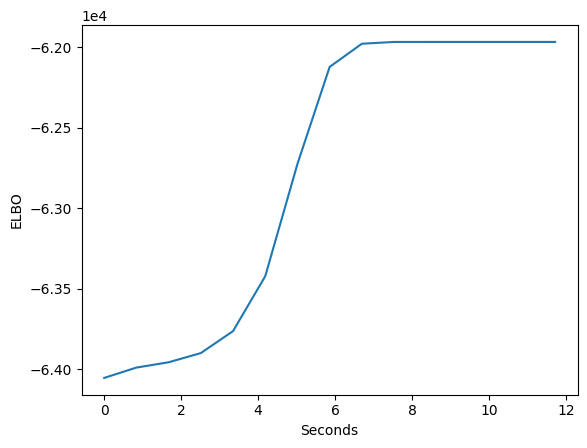

In [157]:
K = 30 # Number of topics
V = 50 # Number of terms in the vocabulary
N = 20 # Number of documents
M = 30 # Number of words per document
ETA = 0.6 # Hyperparameter for V-Dirichlet topics prior
ALPHA = 0.3 # Hyperparameter for K-Dirichlet topics proportion prior
X = sim_LDA(K, V, N, M) # Simulate LDA-collection of documents

start = time.time()
LAMBDA, GAMMA, PHI = init_variation_params(X)
curr_ELBO = 100 # Initialize current ELBO value (initially arbitrarily greater than prev_ELBO)
prev_ELBO = 0 # Initialize previous ELBO value (initially arbitrarily smaller than curr_ELBO)
ELBOs = [] # Store ELBO values for plotting
tol = 10e-10 # Tolerance for convergence of ELBO

while np.abs(curr_ELBO - prev_ELBO) > tol:
    LAMBDA, GAMMA, PHI = update_variation_params(LAMBDA, GAMMA, PHI, X)
    prev_ELBO = curr_ELBO
    curr_ELBO = compute_ELBO(LAMBDA, GAMMA, PHI, X)
    ELBOs.append(curr_ELBO) # Store computed ELBO values

total_time = time.time() - start
plt.xlabel("Seconds")
plt.ylabel("ELBO")
plt.ticklabel_format(style="sci", axis="y", scilimits=(0, 0))

plt.plot(np.linspace(0, total_time, len(ELBOs)), ELBOs)

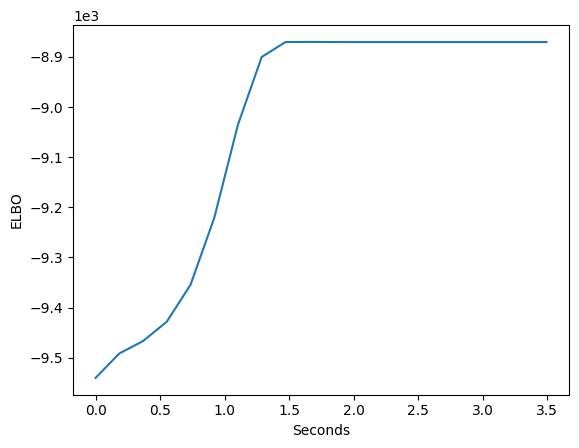

In [30]:
K = 5 # Number of topics
V = 50 # Number of terms in the vocabulary
N = 20 # Number of documents
M = 30 # Number of words per document
ETA = 100 / V # Hyperparameter for V-Dirichlet topics prior
ALPHA = 0.5 # Hyperparameter for K-Dirichlet topics proportion prior
X = sim_LDA(K, V, N, M) # Simulate LDA-collection of documents

start = time.time()
LAMBDA, GAMMA, PHI = init_variation_params(X)
curr_ELBO = 100 # Initialize current ELBO value (initially arbitrarily greater than prev_ELBO)
prev_ELBO = 0 # Initialize previous ELBO value (initially arbitrarily smaller than curr_ELBO)
ELBOs = [] # Store ELBO values for plotting
tol = 10e-10 # Tolerance for convergence of ELBO

# Continue to update variational parameters until ELBO has converged with respect to tolerance (tol)
while np.abs(curr_ELBO - prev_ELBO) > tol:
    # Update variational topic assignment PHI[i, j]
    for i in range(N):
        for j in range(M):
            # Again, x_ij is just an assignment of the vocabulary v=1,...,V so can treat it as such
            x_ij = X[i, j]

            # Calculate the expression inside the exponential for which PHI[i, j] is proportional to
            exp_propto = digamma(LAMBDA[:, x_ij]) - digamma(np.sum(LAMBDA[:, x_ij])) \
                + digamma(GAMMA[i]) - digamma(np.sum(GAMMA[i]))
            
            # Use log-sum-exp trick to normalize PHI[i, j] over k
            PHI[i, j] = np.exp(exp_propto - log_sum_exp(exp_propto))

        # Update variational topic proportions GAMMA[i]
        for k in range(K):
            # Update is ALPHA + sum_{j=1}^M PHI_ijk
            GAMMA[i, k] = ALPHA + np.sum(PHI[i][:, k])

    # Update variational topic LAMBDA[k]
    for k in range(K):
        for v in range(V):
            # Update is ETA + \sum_{i=1}^N \sum_{j=1}^M 1{x_ij = v} PHI_ijk
            LAMBDA[k, v] = ETA + np.sum([[float(X[i,j] == v) * PHI[i, j][k] for i in range(N)] for j in range(M)])
    
    prev_ELBO = curr_ELBO # Set the previous ELBO to the current value of previous iteration
    curr_ELBO = compute_ELBO(LAMBDA, GAMMA, PHI, X) # Compute ELBO for updated parameters; set current ELBO to new ELBO
    ELBOs.append(curr_ELBO) # Store computed ELBO values

    total_time = time.time() - start

plt.xlabel("Seconds")
plt.ylabel("ELBO")
plt.ticklabel_format(style="sci", axis="y", scilimits=(0, 0))

plt.plot(np.linspace(0, total_time, len(ELBOs)), ELBOs)

In [206]:
def init_variation_params(X):
    N, M = X.shape
    LAMBDA = np.random.uniform(low=0.01, high=1.0, size=(K, V))
    GAMMA = np.random.uniform(low=0.01, high=3.0, size=(N, K))
    PHI = np.ones(shape=(N, M, K)) * 1/K

    return LAMBDA, GAMMA, PHI

In [174]:
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter

assert os.path.exists("/Users/daany/Downloads/HT/LDA/ap.txt") and os.path.exists("/Users/daany/Downloads/HT/LDA/vocab.txt")

with open("vocab.txt", "r") as f:
    vocab = set(f.read().splitlines())

with open("ap.txt", "r") as f:
    raw_text = f.read()

texts = re.findall(r"<TEXT>(.*?)</TEXT>", raw_text, re.DOTALL)
stop_words = set(stopwords.words("english"))
documents = []

for text in texts:
    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words and word in vocab]
    documents.append(tokens)

N = len(documents)
V = len(vocab)

doc_term_matrix = np.zeros((N, V))
vocab_to_index = {word: i for i, word in enumerate(vocab)}

for doc_idx, tokens in enumerate(documents):
    token_counts = Counter(tokens)
    for token, count in token_counts.items():
        if token in vocab_to_index:
            term_idx = vocab_to_index[token]
            doc_term_matrix[doc_idx, term_idx] = count

index_to_vocab = dict((val, key) for key, val in vocab_to_index.items())

In [180]:
ETA = 1 / V
ALPHA = 0.1
K = 30 # Number of topics

nonzero_idxs = []
for doc in doc_term_matrix:
    nonzero_idx = np.where(doc > 0)[0]
    nonzero_idxs.append(sorted(nonzero_idx))

def init_variational_params(doc_term_matrix, K):
    N, V = doc_term_matrix.shape # N is number of documents
    LAMBDA = np.random.uniform(low=0.01, high=1.0, size=(K, V))
    GAMMA = np.ones((N, K))
    PHI = []
    for doc in doc_term_matrix:
        num_words_per_doc = np.sum((doc > 0).astype("int32"))
        doc_PHI = np.ones((num_words_per_doc, K))
        doc_PHI = doc_PHI / K
        PHI.append(doc_PHI)

    return LAMBDA, GAMMA, PHI

def compute_ELBO(LAMBDA, GAMMA, PHI, doc_term_matrix, nonzero_idxs, K):
    N, V = doc_term_matrix.shape
    ELBO = 0

    E_log_p_BETA = 0
    for k in range(K):
        E_log_p_BETA += (ETA - 1) * np.sum(digamma(LAMBDA[k]) - digamma(np.sum(LAMBDA[k])))
    ELBO += E_log_p_BETA

    E_log_p_THETA = 0
    for i in range(N):
        E_log_p_THETA += (ALPHA - 1) * np.sum(digamma(GAMMA[i]) - digamma(np.sum(GAMMA[i])))
    ELBO += E_log_p_THETA

    E_q_log_p_z_x = 0
    for i in range(N):
        doc = doc_term_matrix[i]
        nonzero_idx = nonzero_idxs[i]
        corr_idx = 0
        for idx in nonzero_idx:
            E_q_log_p_z_x += doc[idx] * np.sum(PHI[i][corr_idx] * (digamma(GAMMA[i]) - digamma(np.sum(GAMMA[i])))) \
                + doc[idx] * np.sum(PHI[i][corr_idx] * (digamma(LAMBDA[:, idx]) - digamma(np.sum(LAMBDA, axis=1))))
            corr_idx += 1
    ELBO += E_q_log_p_z_x

    E_log_q_BETA = 0
    for k in range(K):
        E_log_q_BETA += -loggamma(np.sum(LAMBDA[k])) + np.sum(loggamma(LAMBDA[k])) \
            - np.sum((LAMBDA[k] - 1) * (digamma(LAMBDA[k]) - digamma(np.sum(LAMBDA[k]))))
    ELBO += E_log_q_BETA

    E_log_q_THETA = 0
    for i in range(N):
        E_log_q_THETA += -loggamma(np.sum(GAMMA[i])) + np.sum(loggamma(GAMMA[i])) \
            - np.sum((GAMMA[i] - 1) * (digamma(GAMMA[i]) - digamma(np.sum(GAMMA[i]))))
    ELBO += E_log_q_THETA

    E_q_log_z = 0
    for i in range(N):
        doc = doc_term_matrix[i]
        nonzero_idx = nonzero_idxs[i]
        corr_idx = 0
        for idx in nonzero_idx:
            E_q_log_z += -doc[idx] * np.sum(PHI[i][corr_idx]) * np.log(PHI[i][corr_idx])
            corr_idx += 1
    ELBO += E_q_log_z

    return ELBO

compute_ELBO(LAMBDA, GAMMA, PHI, doc_term_matrix, nonzero_idxs, K)

array([-1128699.06649297, -1014424.55980429, -1226649.64491216,
        -976951.20314625, -1024241.38665398, -1218373.22285822,
       -1206629.82077011, -1048587.42829499, -1036096.36021448,
       -1013861.61192682,  -792307.62989322, -1114257.25483481,
       -1063381.46568572, -1162794.02531075,  -901785.51115376,
       -1152738.78347649, -1201334.0375141 , -1070177.49034148,
       -1175863.61194651, -1131508.6355553 , -1103479.27637579,
       -1115094.19043909, -1091316.47450244, -1254623.99325333,
       -1048473.04925114, -1139028.2264779 , -1098997.67743886,
        -967964.50902109, -1041167.29998016, -1251338.82272149])

In [179]:
LAMBDA, GAMMA, PHI = init_variational_params(doc_term_matrix, K)
# def update_variational_params(LAMBDA, GAMMA, PHI, doc_term_matrix, nonzero_idxs, K):
N, V = doc_term_matrix.shape

print("Updating PHI and GAMMA")
for i in tqdm(range(N)):
    doc = doc_term_matrix[i]
    nonzero_idx = nonzero_idxs[i]
    corr_idx = 0
    for idx in nonzero_idx:
        log_PHI_ij = np.zeros((K, ))
        for k in range(K):
            exponent = digamma(GAMMA[i][k]) - digamma(np.sum(GAMMA[i])) \
                + digamma(LAMBDA[k][idx]) - digamma(np.sum(LAMBDA[k]))
            log_PHI_ij[k] = exponent
        PHI_ij = np.exp(log_PHI_ij - log_sum_exp(log_PHI_ij))
        PHI[i][corr_idx] = PHI_ij
        corr_idx += 1

    GAMMA_i = np.zeros((K, )) + ALPHA
    for k in range(K):
        GAMMA_i[k] += np.sum(doc[nonzero_idx] * PHI[i][:, k])
    GAMMA[i] = GAMMA_i

print("Updating LAMBDA")
for k in tqdm(range(K)):
    LAMBDA_k = np.zeros((V, )) + ETA
    for i in range(N):
        doc = doc_term_matrix[i]
        nonzero_idx = nonzero_idxs[i]
        corr_idx = 0
        for idx in nonzero_idx:
            LAMBDA_k[idx] += doc[idx] * PHI[i][corr_idx][k]
            corr_idx += 1
    LAMBDA[k] = LAMBDA_k

Updating PHI and GAMMA


100%|██████████| 2246/2246 [02:36<00:00, 14.34it/s]


Updating LAMBDA


100%|██████████| 30/30 [00:08<00:00,  3.52it/s]
